## Data correction procedure for TOF-SANS with polarization analysis

TO BE OVERWRITTEN AFTER EVERYTHING IS MERGED TO MAIN

AT THE END: DEFINE ALL NOTATIONS FOR INTENSITIES ETC, EG I0, I_DEPOL, ...

1) Overview and general workflow
2) Readout of test-data
3) Definition of ROI
4) Data correction


1) Overview and general workflow

Different to unpolarized SANS, the spin-dependent cross section $\vec{S}$ after sample-scattering are correlated and cannot be corrected individually [Ref 1, 2, 3]. Instead, a beamline-component dependent correction Matrix $\hat{M}$ has to be applied to all spin-dependent measurements simultaneously to retrieve $\vec{S}$ from the measured intensities $\vec{I}$:

\begin{equation}
\begin{pmatrix} I^{++} \\ I^{+-}  \\ I^{-+} \\  I^{--}\end{pmatrix} = \hat{M} \\
\begin{pmatrix} S^{++} \\ S^{+-}  \\ S^{-+} \\  S^{--}\end{pmatrix}
\label{eq:T} 
\end{equation}

Here, we describe the correction of TOF-SANS data with polarization analysis of the esspolarization package using two time-dependent $^3$He-polarized cells. Hence, the polarization-related beamline components in $\hat{M}$ are the time- and spin-dependent transmission matrices of the $^3$He-polarizer $\hat{T^p}$ and $^3$He-analyzer $\hat{T^a}$. Both $\hat{T^p}$ and $\hat{T^a}$ can be derived from:

$\hat{T}^{\pm}(t,\lambda) = T_g*e^{-O(\lambda)\pm O(\lambda)*P_{3He}(t)}$,

with the transmission of the empty cell $T_g$,  the cell opacity $O$, and the nuclear polarization of the cell $P_{3He}(t)$.
This general method for time-dependent $^3$He-cells can be adapted for other use-cases such as using supermirrors or in-situ polarized 3He-cells, see "Note" at the end of the page. 

First, the created test-data needs to be readout and grouped by purpose, e.g., if it describes a sample-run, a direct-beam-run, or a background measurement without cells and sample. All data will be reduced (PROBABLY BEAMLINE SPECIFIC?) using the normalization term described in https://scipp.github.io/ess/techniques/sans/sans-beam-center-finder.html. Second, for the calculation of time-dependent $P_{3He}(t)$, the ROI's of the direct-beam region and background region have to be defined (USING BEAMCENTER FINDER OPTION OF SANS2D?). Third, we will describe the data correction workflow with a calculation of $O$, $P_{3He}(t)$, and $T^{\pm}$ of the polarizer and analyzer, and the application on the sample-data.

To facilitate an in-situ data correction during the experiments, we have implemented two different approaches: (i) a rough data-correction based on a $^3$He-cell opacity calculated by its cell parameters and filling pressure ("workflow 1") which can be used in-situ during the experiment, and (ii) a precise calculation based on the calculation of opacity by a direct-beam measurement on the depolarized cell at its end of lifetime (i.e., end of cell-usage for this experiment) ("workflow 2"): 

Workflow 1:
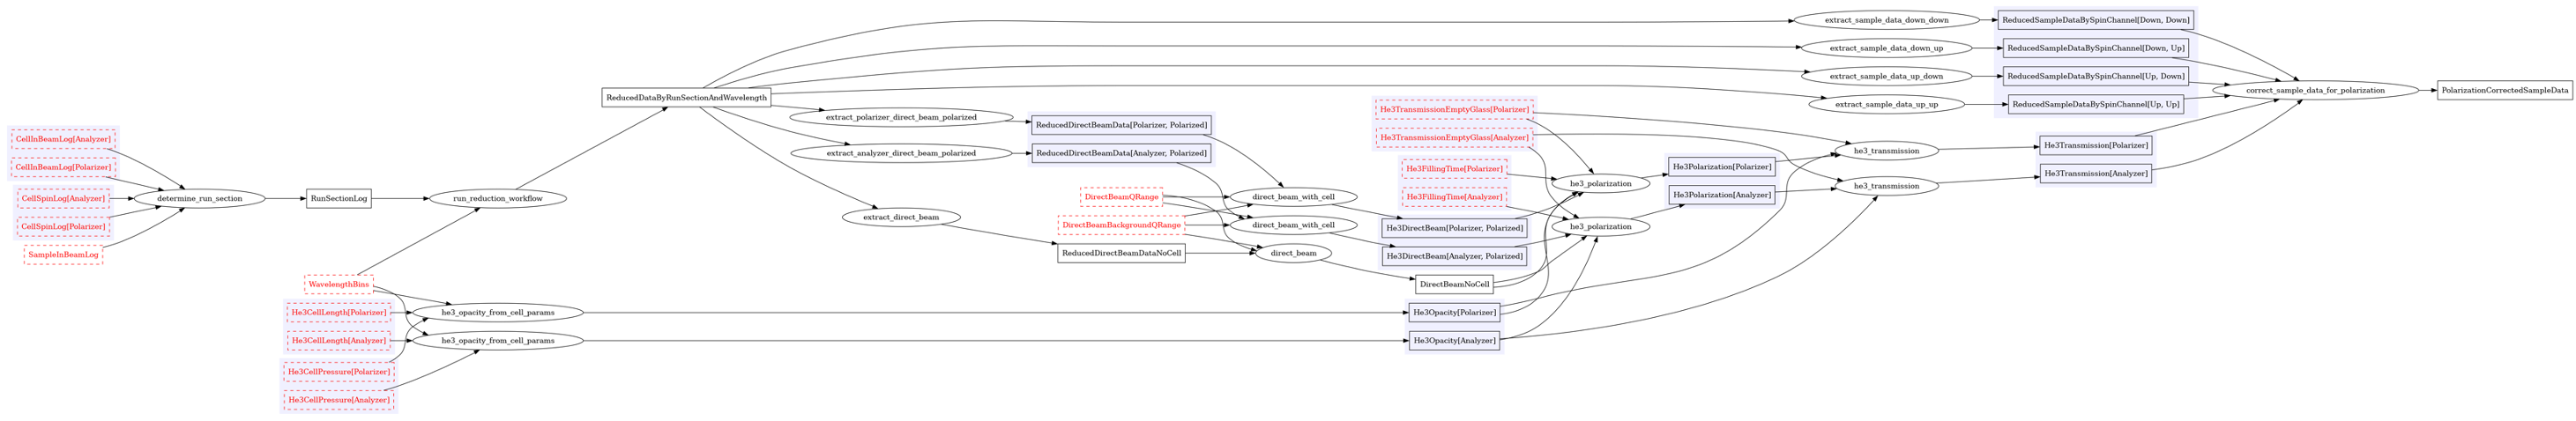

Workflow 2:
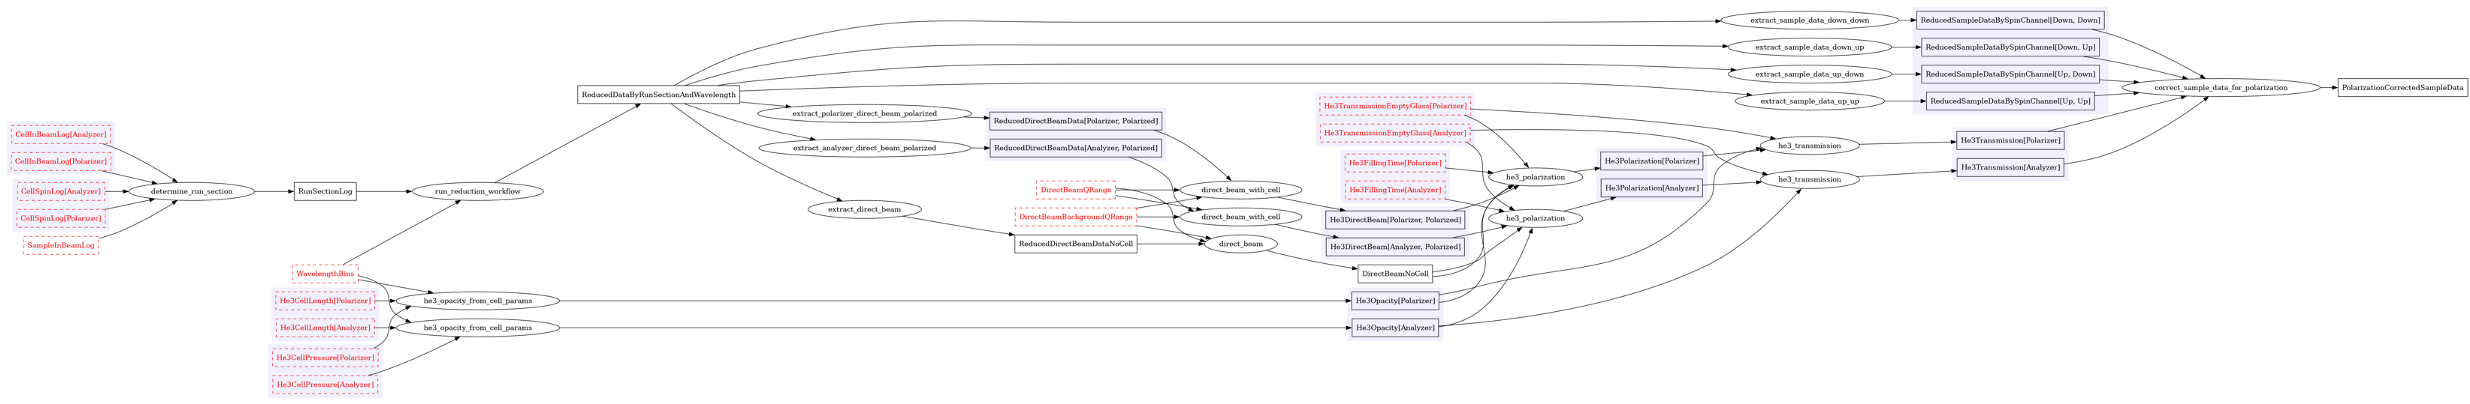


2) Readout of test-data

--> TOF-specific: Need to keep time-information after binning into wavelengthbins.

In [1]:
def determine_run_section(
    sample_in_beam: SampleInBeamLog,
    polarizer_in_beam: CellInBeamLog[Polarizer],
    analyzer_in_beam: CellInBeamLog[Analyzer],
    polarizer_spin: CellSpinLog[Polarizer],
    analyzer_spin: CellSpinLog[Analyzer],
) -> RunSectionLog:
    from scipp.scipy.interpolate import interp1d

    logs = {
        'sample_in_beam': sample_in_beam,
        'polarizer_in_beam': polarizer_in_beam,
        'analyzer_in_beam': analyzer_in_beam,
        'polarizer_spin': polarizer_spin,
        'analyzer_spin': analyzer_spin,
    }
    # TODO Change this to datetime64
    times = [
        log.coords['time'].to(unit='s', dtype='float64', copy=False)
        for log in logs.values()
    ]
    times = sc.concat(times, 'time')
    times = sc.array(dims=times.dims, unit=times.unit, values=np.unique(times.values))
    logs = {
        name: interp1d(log, 'time', kind='previous', fill_value='extrapolate')(times)
        for name, log in logs.items()
    }
    return RunSectionLog(sc.Dataset(logs))

NameError: name 'SampleInBeamLog' is not defined

In [ ]:
def dummy_reduction(....
    )


def run_reduction_workflow(
    run_section: RunSectionLog,
    wavelength_bands: WavelengthBins,
) -> ReducedDataByRunSectionAndWavelength:
    data = dummy_reduction(
        time_bands=run_section.coords['time'],
        wavelength_bands=wavelength_bands,
    )
    for name, log in run_section.items():
        data.coords[name] = log.data
    return ReducedDataByRunSectionAndWavelength(data)

In [ ]:
def extract_direct_beam(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedDirectBeamDataNoCell:
    """Extract direct beam without any cells from direct beam data."""
    is_direct_beam = ~(
        data.coords['sample_in_beam']
        | data.coords['polarizer_in_beam']
        | data.coords['analyzer_in_beam']
    )
    # We select all bins that correspond to direct-beam run sections. This preserves
    # the separation into distinct direct beam runs, which is required later for
    # fitting a time-decay function.
    return ReducedDirectBeamDataNoCell(data[is_direct_beam])


def extract_polarizer_direct_beam_polarized(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedDirectBeamData[Polarizer, Polarized]:
    """Extract run sections with polarized polarizer from direct beam data."""
    # TODO We need all "polarized" runs, can we assume that
    # ReducedDataByRunSectionAndWavelength does not contain any depolarized data?
    select = (
        data.coords['polarizer_in_beam']
        & ~data.coords['sample_in_beam']
        & ~data.coords['analyzer_in_beam']
    )
    return ReducedDirectBeamData[Polarizer, Polarized](data[select])


def extract_analyzer_direct_beam_polarized(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedDirectBeamData[Analyzer, Polarized]:
    """Extract run sections with polarized analyzer from direct beam data."""
    # TODO We need all "polarized" runs, can we assume that
    # ReducedDataByRunSectionAndWavelength does not contain any depolarized data?
    select = (
        data.coords['analyzer_in_beam']
        & ~data.coords['sample_in_beam']
        & ~data.coords['polarizer_in_beam']
    )
    return ReducedDirectBeamData[Analyzer, Polarized](data[select])

def is_sample_channel(
    coords: Mapping[str, sc.Variable],
    polarizer_spin: sc.Variable,
    analyzer_spin: sc.Variable,
) -> sc.Variable:
    return (
        coords['sample_in_beam']
        & coords['polarizer_in_beam']
        & coords['analyzer_in_beam']
        & (coords['polarizer_spin'] == polarizer_spin)
        & (coords['analyzer_spin'] == analyzer_spin)
    )


def extract_sample_data_up_up(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedSampleDataBySpinChannel[Up, Up]:
    """Extract sample data for spin channel up-up."""
    return ReducedSampleDataBySpinChannel[Up, Up](
        is_sample_channel(data, spin_up, spin_up)
    )


def extract_sample_data_up_down(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedSampleDataBySpinChannel[Up, Down]:
    """Extract sample data for spin channel up-down."""
    return ReducedSampleDataBySpinChannel[Up, Down](
        is_sample_channel(data, spin_up, spin_down)
    )


def extract_sample_data_down_up(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedSampleDataBySpinChannel[Down, Up]:
    """Extract sample data for spin channel down-up."""
    return ReducedSampleDataBySpinChannel[Down, Up](
        is_sample_channel(data, spin_down, spin_up)
    )


def extract_sample_data_down_down(
    data: ReducedDataByRunSectionAndWavelength,
) -> ReducedSampleDataBySpinChannel[Down, Down]:
    """Extract sample data for spin channel down-down."""
    return ReducedSampleDataBySpinChannel[Down, Down](
        is_sample_channel(data, spin_down, spin_down)
    )

3. Definition of ROI

In [ ]:
def compute_direct_beam(
    data: sc.DataArray,
    q_range: sc.Variable,
    background_q_range: sc.Variable,
) -> sc.DataArray:
    """Compute background-subtracted direct beam function."""
    start_db = q_range[0]
    stop_db = q_range[-1]
    start_bg = background_q_range[0]
    stop_bg = background_q_range[-1]
    # The input is binned in time and wavelength, we simply histogram without changes.
    direct_beam = data.bins['Q', start_db:stop_db].hist()
    background = data.bins['Q', start_bg:stop_bg].hist()
    return direct_beam - background

def direct_beam(
    data: ReducedDirectBeamDataNoCell,
    q_range: DirectBeamQRange,
    background_q_range: DirectBeamBackgroundQRange,
) -> DirectBeamNoCell:
    """
    Returns the direct beam function without any cells.

    The result is background-subtracted and returned as function of wavelength.
    Other dimensions of the input are preserved. In particular, the time dimension,
    corresponding to different direct beam measurements, is preserved.
    """
    return DirectBeamNoCell(
        compute_direct_beam(
            data=data,
            q_range=q_range,
            background_q_range=background_q_range,
        )
    )


def direct_beam_with_cell(
    data: ReducedDirectBeamData[Cell, PolarizationState],
    q_range: DirectBeamQRange,
    background_q_range: DirectBeamBackgroundQRange,
) -> He3DirectBeam[Cell, PolarizationState]:
    """
    Returns the direct beam function for a given cell.

    The result is background-subtracted and returned as function of wavelength and
    wall-clock time. The time dependence is coarse, i.e., due to different time
    intervals at which the direct beam is measured.
    """
    return He3DirectBeam[Cell, PolarizationState](
        compute_direct_beam(
            data=data,
            q_range=q_range,
            background_q_range=background_q_range,
        )
    )

4. Data correction

4.1 Calculation of $^3$He opacity 

The $^3$He opacity is a cell-specific parameter and can vary after each filling process. It is given by the cell pressure $p$ at 20$\degree$, its length $l$, and the neutron wavelength $\lambda$ (Ref 1):

$O(\lambda)= 0.0733 pl \lambda$,

with a factor 0.0733 arising from the number density of $^3$He gas and the absortopn cross section of 1$\mathring A$ neutrons by $^3$He. For an in-situ quick data correction, a measure of $p$ during filling the cell can serve as input to above equation, leading to "workflow 1". A more precise data correction is based on a measure of $p$ by a direct-beam measurement through the depolarized cell (i.e., $P_{3He}(t) \rightarrow 0$)(Ref. 2), leading to "workflow 2". For $P_{3He}(t) \rightarrow 0$ and an unpolarized incident beam (i.e., $\hat{T}_{unpol} = (\hat{T}^++\hat{T}^-)/2$), the neutron transmission \eqref{eq:T} becomes:

$T_{unpol}=T_ge^{-O(\lambda)}$,

leading to following derivation by neutron experiment:

$I_{depol}/I_0=T_ge^{-O(\lambda)}$.

For a measurement of $I_{depol}$, the $^3$He cell needs to be depolarized at the end of its lifetime and a direct-beam measurement though the cell has to be performed without polarizer, analyzer, and sample. Different Ref. 2, for TOF experiments the wavelength dependence of the opacity has to be taken into account. To calculate $O$ for all wavelength from the depolarized direct-beam data $I_{depol}$, the scipp-function reduce_dims() of the scipp.curve_fit package will be employed, yielding the wavelength-independent part $o$ of $O(\lambda)$ in above equation. Afterwards, the wavelength-dependence can be retrieved by setting $O(\lambda)=o\lambda$.

In [ ]:
#Workflow 1:
def he3_opacity_from_cell_params(
    pressure: He3CellPressure[Cell],
    cell_length: He3CellLength[Cell],
) -> He3Opacity[Cell]:

    return He3Opacity[Cell](0.07733 * pressure * cell_length)

#Workflow 2:
def he3_opacity_from_beam_data(
    transmission_empty_glass: He3TransmissionEmptyGlass[Cell],
    direct_beam: DirectBeamNoCell,
    direct_beam_cell: He3DirectBeam[Cell, Depolarized],
) -> He3Opacity[Cell]:
    
    def Intensity_direct_beam_cell(time, opacity_cell):
        return direct_beam*transmission_empty_glass*sc.exp(-opacity_cell)
    
    popt, pcov = sc.curve_fit(['time'], reduce_dims = ['wavelength'], Intensity_direct_beam_cell, direct_beam_cell)
    raise NotImplementedError()
    return He3Opacity[Cell](popt)

4.2 Calculation of time-dependent 3He-polarization



--> TOF-specific: wavelength dependence of opacity, and calculation of one single value for all wavelengths.

In [ ]:
def he3_polarization(
    direct_beam_no_cell: DirectBeamNoCell,
    direct_beam_polarized: He3DirectBeam[Cell, Polarized],
    opacity: He3Opacity[Cell],
    filling_time: He3FillingTime[Cell],
    wavelength: WavelengthBins,
    transmission_empty_glass: He3TransmissionEmptyGlass[Cell],
) -> He3Polarization[Cell]:

    def polarization(time, P_He0, T1):
        return P_He0*np.exp(-time/T1)

    def Intensity_DB_polarized(time, P_He0, T1):    
        return direct_beam_no_cell*transmission_empty_glass*np.exp(-opacity*wavelength)*np.cosh(opacity*wavelength*polarization(time, P_He0, T1))

    popt, pcov = sc.curve_fit(['time'], reduce_dims=['wavelength'], Intensity_DB_polarized, direct_beam_polarized)

    raise NotImplementedError()
    return He3Polarization[Cell](polarization(time,**popt))

4.3 Spin-dependent transmission values

--> TOF-specific: wavelength dependence of opacity, and calculation of one single value for all wavelengths.

In [ ]:
def he3_transmission(
    opacity: He3Opacity[Cell],
    polarization: He3Polarization[Cell],
    transmission_empty_glass: He3TransmissionEmptyGlass[Cell],
) -> He3Transmission[Cell]:

4.4 Sample data correction

In [ ]:
def correct_sample_data_for_polarization(
    upup: ReducedSampleDataBySpinChannel[Up, Up],
    updown: ReducedSampleDataBySpinChannel[Up, Down],
    downup: ReducedSampleDataBySpinChannel[Down, Up],
    downdown: ReducedSampleDataBySpinChannel[Down, Down],
    transmission_polarizer: He3Transmission[Polarizer],
    transmission_analyzer: He3Transmission[Analyzer],
) -> PolarizationCorrectedSampleData:

Literature: 
1) Wai Tung Lee et al., Polarisation Development at the European Spallation Source
2) Kathryn Krycka et al., Polarization-analyzed small-angle neutron scattering. I. Polarized data reduction using Pol-Corr
3) A. Wildes
4) Difference SEOP - MEOP: Optically polarized 3He, T. Gentile et al., 

Note 1:
This workflow can be applied on polarization analyzed sample-data using two time-dependent ex-situ polarized 3He-based spin filters as both polarizer and analyzer. To be used for the instruments SKADI and DREAM, following adaptations have to be made:
1: DREAM operated with a movable in-situ SEOP 3He-polarizer and a movable ex-situ SEOP small-angle 3He-analyzer (nm-SANS-option):
--> the polarizer is continuously pumped and considered as time-independent. Values like the opacity, nuclear polarization, and transmission will be pre-characterized and inserted to the workflow as constant parameters.
2: DREAM operated with a movable in-situ SEOP 3He-polarizer and a NOT-movable ex-situ MEOP wide-angle 3He-analyzer 
--> for the polarizer, the same treatment as stated in 1. will be applied. For the analyzer a new workflow considering that the analyzer cannot be moved out of the beam has to be written.
3: SKADI operated with a movable supermirror V-cavity polarizer, a spin flipper, and a movable ex-situ SEOP/MEOP 3He-analyzer:
--> The supeprmirror polarizer (time-independent and wavelength-dependent) and spin flipper transmission values can be pre-characterized and inserted to the workflow as constant parameters. For the analyzer, the current workflow can be adapted.

Note 2:
MAYBE INSERT IN FUTURE SAMPLE DEPOLARIZATION AS WELL?

NOTE 3:
esp. for using flippers: 
Determination of corretion matrices using standard samples as desceribed in A. Wildes